In [1]:
import sys
sys.path.append('../src')
import P_binary
import P_random
import P_posterior
import const as c
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from numpy.random import normal

%matplotlib inline

### Load NLTT Catalog

In [2]:
# Read in sample from Tycho-2 table
filename = ('../data/rNLTT/catalog_tabs.dat')
t_full = Table.read(filename, format='ascii', guess=True)

# Change proper motion units from asec/yr to mas/yr
t_full['mu_ra'] = 1.0e3*t_full['mu_ra']
t_full['mu_dec'] = 1.0e3*t_full['mu_dec']
t_full['mu_ra_err'] = 1.0e3*t_full['mu_ra_err']
t_full['mu_dec_err'] = 1.0e3*t_full['mu_dec_err']

# Select only stars with proper motion uncertainties greater than 1 mas/yr - remove junk
ids_good = np.union1d( np.where(t_full['mu_ra_err'] > 1.0)[0], \
                      np.where(t_full['mu_dec_err'] > 1.0)[0] )
t = t_full[ids_good]

### Load Chaname & Gould (2004) catalog

In [3]:
# Read in pairs identified by Chaname & Gould

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
CG_pairs = CG_pairs[0:-1]  # Because the last line is blank

### Let's pick one pair and test

In [4]:
id1 = 1012.
id2 = 1018.

i = np.argmin(np.abs(id1 - t['NLTT']))
j = np.argmin(np.abs(id2 - t['NLTT']))

star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], \
        t['mu_ra_err'][i], t['mu_dec_err'][i]
star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], \
        t['mu_ra_err'][j], t['mu_dec_err'][j]

In [5]:
pos_density = P_random.get_sigma_pos(star1[0], star1[1], catalog=t, method='kde')
pm_density = P_random.get_sigma_mu(star1[2], star1[3], catalog=t, method='kde')

delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)


prob_post = np.array([])
prob_pos = np.array([])
prob_mu = np.array([])
num_samples = 10**np.linspace(1, 5, 25)
for n in num_samples:

    P_post, P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                    star1[2], star1[3], star2[2], star2[3],
                                    delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                    pos_density=pos_density, pm_density=pm_density,
                                    nsamples=n, catalog=t)
    
    
    prob_post = np.append(prob_post, P_post)
    prob_pos = np.append(prob_pos, P_pos)
    prob_mu = np.append(prob_mu, P_mu)

    


../src/P_random.py:304: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  delta_mu_ra = normal(loc=(mu_ra1-mu_ra2), scale=delta_mu_ra_err, size=nsamples)
../src/P_random.py:305: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  delta_mu_dec = normal(loc=(mu_dec1-mu_dec2), scale=delta_mu_dec_err, size=nsamples)


In [7]:
P_binary.generate_binary_set(num_sys=100000)

In [8]:
theta = P_random.get_theta_proj_degree(t['ra'][i], t['dec'][i], t['ra'][j], t['dec'][j])


prob_bin = np.array([])
num_samples = 10**np.linspace(1, 5, 2)
for n in num_samples:

    delta_mu_ra_sample = normal(loc=(t['mu_ra'][i] - t['mu_ra'][j]), \
                                scale=delta_pm_ra_err, \
                                size=n)
    delta_mu_dec_sample = normal(loc=(t['mu_dec'][i] - t['mu_dec'][j]), \
                                 scale=delta_pm_dec_err, \
                                 size=n)
    delta_mu_sample = np.sqrt(delta_mu_ra_sample**2 + delta_mu_dec_sample**2)

    # Monte Carlo integrate observational uncertainties on delta mu
    prob_tmp = P_binary.get_P_binary(theta * 3600.0, delta_mu_sample)
    prob_bin = np.append(prob_bin, 1.0/n * np.sum(prob_tmp))
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

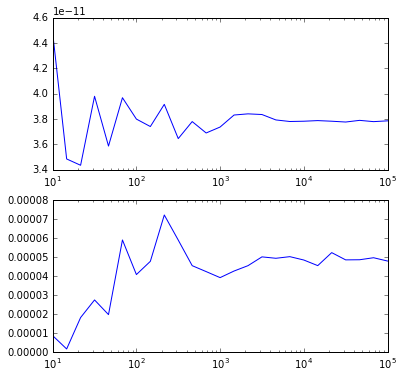

In [67]:
fig, ax = plt.subplots(2,1, figsize=(6,6))


ax[0].plot(num_samples, prob_post)
ax[1].plot(num_samples, prob_bin)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
    
plt.show()

### Now, let's test the convergence of get_P_random_alignment

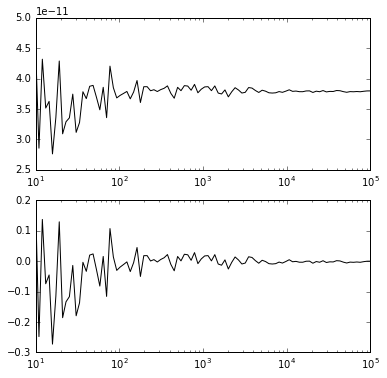

In [17]:
delta_mu_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
delta_mu_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
    

num_samples = 10**np.linspace(1, 5, 100)
prob_random_out = np.array([])
for n in num_samples:

    prob_random, prob_pos, prob_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                      star1[2], star1[3], star2[2], star2[3],
                                      delta_mu_ra_err=delta_mu_ra_err, delta_mu_dec_err=delta_mu_dec_err,
                                      nsamples=n,
                                      catalog=t)
    
    prob_random_out = np.append(prob_random_out, prob_random)
    
    
fig, ax = plt.subplots(2,1, figsize=(6,6))
    
ax[0].plot(num_samples, prob_random_out, color='k')
ax[0].set_xscale('log')

ax[1].plot(num_samples, (prob_random_out-prob_random_out[-1])/prob_random_out[-1], color='k')
ax[1].set_xscale('log')

plt.show()

### Let's perform convergence on the full posterior on one particular sample

In [2]:
# First we load the catalog
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8'),('d_Q','<f8'),('noise','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(16):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)



    tgas = np.zeros(len(tgas_tmp), dtype=dtype)
                                                  # Gaia units
    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']                   # degrees
    tgas['dec'] = tgas_tmp['dec']                 # degrees
    tgas['mu_ra'] = tgas_tmp['pmra']              # mas/yr
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']    # mas/yr
    tgas['mu_dec'] = tgas_tmp['pmdec']            # mas/yr
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']  # mas/yr
    tgas['plx'] = tgas_tmp['parallax']            # mas
    tgas['plx_err'] = tgas_tmp['parallax_error']  # mas
    tgas['d_Q'] = tgas_tmp['astrometric_delta_q']
    tgas['noise'] = tgas_tmp['astrometric_excess_noise_sig']

    tgas_full = np.append(tgas_full, tgas)

../data/TGAS/TgasSource_000-000-000.csv
../data/TGAS/TgasSource_000-000-001.csv
../data/TGAS/TgasSource_000-000-002.csv
../data/TGAS/TgasSource_000-000-003.csv
../data/TGAS/TgasSource_000-000-004.csv
../data/TGAS/TgasSource_000-000-005.csv
../data/TGAS/TgasSource_000-000-006.csv
../data/TGAS/TgasSource_000-000-007.csv
../data/TGAS/TgasSource_000-000-008.csv
../data/TGAS/TgasSource_000-000-009.csv
../data/TGAS/TgasSource_000-000-010.csv
../data/TGAS/TgasSource_000-000-011.csv
../data/TGAS/TgasSource_000-000-012.csv
../data/TGAS/TgasSource_000-000-013.csv
../data/TGAS/TgasSource_000-000-014.csv
../data/TGAS/TgasSource_000-000-015.csv


### First, let's show convergence on the integral for the normalization constant

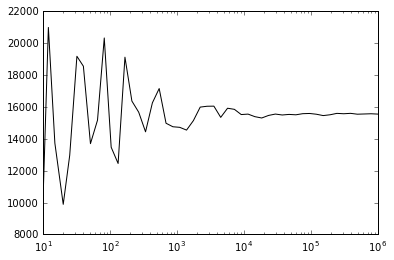

In [5]:
ntot = 50
num_samples = (10**np.linspace(1, 6, ntot)).astype('i8')
const_norm = np.zeros(ntot)

for i, n in zip(np.arange(ntot), num_samples):
    P_random.set_prior_normalization(tgas_full, num_sys=n)
    
    const_norm[i] = P_random.C1_prior_norm
    
plt.plot(num_samples, const_norm, color='k')
plt.xscale('log')

plt.show()

### Now, let's show convergence of probabilities as a function of random draws for Monte Carlo integration

In [16]:
import types

ntot = 20
num_samples = (10**np.linspace(2, 5, ntot)).astype('i8')
prob_posterior = np.zeros(ntot)
prob_binary = np.zeros(ntot)
prob_random = np.zeros(ntot)


for i, n in zip(np.arange(ntot), num_samples):
    prob_out = P_posterior.match_binaries(tgas_full, sys_start=50007, subsample=1, 
                                          size_integrate_full=n, size_integrate_plx=n)
    
    if prob_out.shape == (0,): continue
        
    prob_posterior[i] = prob_out['P_posterior'][0]
    prob_binary[i] = prob_out['P_binary'][0]
    prob_random[i] = prob_out['P_random'][0]

Generating binaries...
Done generating binaries
Calculating normalization for random alignment prior...
Done setting prior.
We are testing 2057050 stars...
Elapsed time: 2.28462314606 seconds
Generating binaries...
Done generating binaries
Calculating normalization for random alignment prior...
Done setting prior.
We are testing 2057050 stars...
Elapsed time: 2.45246505737 seconds
Generating binaries...
Done generating binaries
Calculating normalization for random alignment prior...
Done setting prior.
We are testing 2057050 stars...
Elapsed time: 2.84337091446 seconds
Generating binaries...
Done generating binaries
Calculating normalization for random alignment prior...
Done setting prior.
We are testing 2057050 stars...
50007 50008 241194746185660544 241194746185661952 30.5089382703 -0.0847370074823 -5.00820833566 0.73817781164 -6.59565508119 1.62887967183 0.224643229387 1.21301046194 0.343632579799 3.6562466983e-09 0.00390921425038 0.469943671752
Elapsed time: 3.1096739769 seconds
G

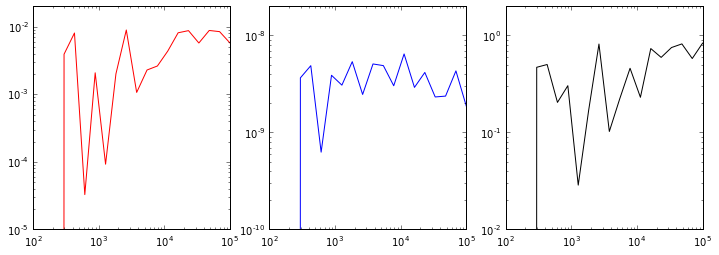

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].plot(num_samples, prob_binary, color='r')
ax[1].plot(num_samples, prob_random, color='b')
ax[2].plot(num_samples, prob_posterior, color='k')

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')

ax[0].set_ylim(1.0e-5, 2.0e-2)
ax[1].set_ylim(1.0e-10, 2.0e-8)
ax[2].set_ylim(1.0e-2, 2.0)

plt.show()